__author__ = 'Armando Collado-Villaverde'  
__email__ = 'armando.collado@uah.es'

# SUPERPOSED EPOCH ANALYSIS FOR THE ASY-H STORMS OF EACH INTENSITY CLASS
Contains the superposed epoch analysis for the SYM and ASY indices, the storms are selected and classified based on the thresholds calculated on the previous notebook. 5 days are selected before and after the peak value of each storm. Then, storms from the same class are averaged using the peak value of the index as the 0 epoch.  

* [ASY-H STORMS](#section_1)
* [SUPERPOSED PLOTS](#section_2)
  * [Forward](#section_2_1)
  * [Backward](#section_2_2)
  * [Both directions](#section_2_3)
  * [PELT analysis](#section_2_4)

In [1]:
import pandas as pd
import utils
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ruptures as rpt

# Set seaborn styles for the plots
sns.set_style('whitegrid')
sns.set_context("paper")

In [2]:
print('Selecting storms based on the findings of the distribution of the maximum of the ASY-H index when grouping in 27 days to avoid persistence')
print('The found storms will be used to perform the superposed epoch analysis')

# Print threshold information for classification
print(f'Times when the ASY-H is below {utils.ASY_H_THRESHOLD_LOW} (percentile 60) will be ignored')
print(f'Times when the ASY-H is between {utils.ASY_H_THRESHOLD_LOW} and {utils.ASY_H_THRESHOLD_MODERATE} (percentile 80) will be classified as "LOW"')
print(f'Times when the ASY-H is between {utils.ASY_H_THRESHOLD_MODERATE} and {utils.ASY_H_THRESHOLD_INTENSE} (percentile 95) will be classified as "MODERATE"')
print(f'Times when the ASY-H is between {utils.ASY_H_THRESHOLD_INTENSE} and {utils.ASY_H_THRESHOLD_SUPERINTENSE} (percentile 99) will be classified as "INTENSE"')
print(f'Times when the ASY-H is above {utils.ASY_H_THRESHOLD_SUPERINTENSE} will be classified as "SUPERINTENSE"')

Selecting storms based on the findings of the distribution of the maximum of the ASY-H index when grouping in 27 days to avoid persistence
The found storms will be used to perform the superposed epoch analysis
Times when the ASY-H is below 130 (percentile 60) will be ignored
Times when the ASY-H is between 130 and 170 (percentile 80) will be classified as "LOW"
Times when the ASY-H is between 170 and 290 (percentile 95) will be classified as "MODERATE"
Times when the ASY-H is between 290 and 540 (percentile 99) will be classified as "INTENSE"
Times when the ASY-H is above 540 will be classified as "SUPERINTENSE"


In [3]:
# Read data from pickle file
dfx = pd.read_pickle('./data/sym_asy_indices.pkl', compression = 'gzip')

invalid_dates_asy = [
                 '2003-11-05 17:20:00',
                 '2003-11-05 17:25:00',
                 '2003-11-10 13:10:00',
                 '2003-11-10 17:20:00',
                 '2003-11-10 17:25:00',
                 '2003-11-24 15:00:00',    
                 '2003-06-27 23:45:00',
                 '2003-06-27 23:50:00',
                 '2003-06-27 23:55:00',
                 '2003-11-03 10:10:00',
                ]

dfx.loc[invalid_dates_asy, 'ASY_H'] = np.nan
dfx[['ASY_H']] = dfx[['ASY_H']].interpolate()

## ASY-H STORMS <a class="anchor" id="section_1"></a>

In [4]:
# Extract dates with ASY-H index values above or equal to the low threshold
dates_asy = dfx['ASY_H'].reset_index().copy()
dates_asy = dates_asy.loc[dates_asy['ASY_H'] >= utils.ASY_H_THRESHOLD_LOW]

# Set the last valid year for storm classification
last_valid_year = 2022

# Initialize empty list to store storm data
storms_asy = []

Iterate over the dates with ASY-H values above the low intensity threhold.

* Calculate the start and end dates for the storm period based on the current date using one day as the offset.
* Find the maximum ASY-H value within the storm period.
* Find the index of the storm center (first occurrence of the maximum ASY-H value).
* Calculates the extended start and end dates for the storm period, considering 5 additional days before and after for the superposed epoch analysis.
* Checks if the end date exceeds the last valid year for classification and skips the current date if it does.
* Extracts the storm data within the extended period.
* Checks if there are more storms within the extended period with higher ASY-H values and updates the storm data accordingly.
* Checks if the new storm period overlaps with the previous storm and merges them if it does.
* Adds the new storm data to the list.

In [5]:
for i in range(len(dates_asy)):
    st = dates_asy.iloc[i]['datetime'] - utils.MINIMUM_DAYS_BEFORE
    nd = dates_asy.iloc[i]['datetime'] + utils.MINIMUM_DAYS_AFTER
    storm_max = dfx[st:nd]['ASY_H'].max()      
    storm_center = dfx[st:nd].loc[dfx[st:nd]['ASY_H'] == storm_max].last_valid_index()    
    
    newst = storm_center - utils.SUPERPOSED_OFFSET_DAYS_BEFORE
    newst = newst.floor('D')
    newnd = storm_center + utils.SUPERPOSED_OFFSET_DAYS_AFTER
    newnd = newnd.ceil('D')
    
    if (newnd.year > last_valid_year):
        continue
    
    new_df = dfx[newst:newnd].copy()
    
    while new_df['ASY_H'].max() > storm_max:
        storm_center = dfx[newst:newnd].loc[dfx[newst:newnd]['ASY_H'] == storm_max].last_valid_index()
        newnd = storm_center + utils.SUPERPOSED_OFFSET_DAYS_AFTER
        newnd = newnd.ceil('D')
        new_df = dfx[newst : newnd].copy()
        storm_max = new_df[newst:newnd]['ASY_H'].max()        
    
    if (len(storms_asy) >= 1):
        if storms_asy[-1].index[-1] >= newst:
            new_df = pd.concat([storms_asy[-1], new_df])            
            new_df = new_df[~new_df.index.duplicated(keep='first')]
            storms_asy[-1] = new_df
            continue
    
    storms_asy.append(new_df)

In [6]:
print(f"Total storms: {len(storms_asy)}")    

Total storms: 258


In [7]:
# Create a summary dataframe with the start and end dates, the duration, the maximum ASY-H value 
# of the storm and the corresponding class of the storm
summary_df_asy = utils.get_summary_df_asy(storms_asy)
summary_df_asy['classification'] = 'LOW'
summary_df_asy.loc[(summary_df_asy['Max ASY-H'] >= utils.ASY_H_THRESHOLD_MODERATE) & (summary_df_asy['Max ASY-H'] < utils.ASY_H_THRESHOLD_INTENSE), 'classification'] = 'MODERATE'
summary_df_asy.loc[(summary_df_asy['Max ASY-H'] >= utils.ASY_H_THRESHOLD_INTENSE) & (summary_df_asy['Max ASY-H'] < utils.ASY_H_THRESHOLD_SUPERINTENSE), 'classification'] = 'INTENSE'
summary_df_asy.loc[summary_df_asy['Max ASY-H'] >= utils.ASY_H_THRESHOLD_SUPERINTENSE, 'classification'] = 'SUPERINTENSE'

In [8]:
# Display all the identified storms
with pd.option_context('display.max_rows', 400, 'display.max_columns', 20):
    display(summary_df_asy) 
print(f'Total storms shown: {len(summary_df_asy)}')

,Start date,End date,TD,Max ASY-H,classification
0,1981-02-28,1981-03-11,11 days,132.0,LOW
1,1981-04-08,1981-04-19,11 days,267.0,MODERATE
2,1981-05-05,1981-05-24,19 days,173.0,MODERATE
3,1981-07-20,1981-07-31,11 days,287.0,MODERATE
4,1981-10-09,1981-10-20,11 days,245.0,MODERATE
5,1982-01-28,1982-02-08,11 days,142.0,LOW
6,1982-02-25,1982-03-08,11 days,193.0,MODERATE
7,1982-07-09,1982-07-19,10 days,604.0,SUPERINTENSE
8,1982-08-02,1982-08-13,11 days,147.0,LOW
9,1982-09-01,1982-09-12,11 days,376.0,INTENSE


Total storms shown: 258


classification
LOW             150
MODERATE         81
INTENSE          21
SUPERINTENSE      6
Name: count, dtype: int64
Total number of storms: 258


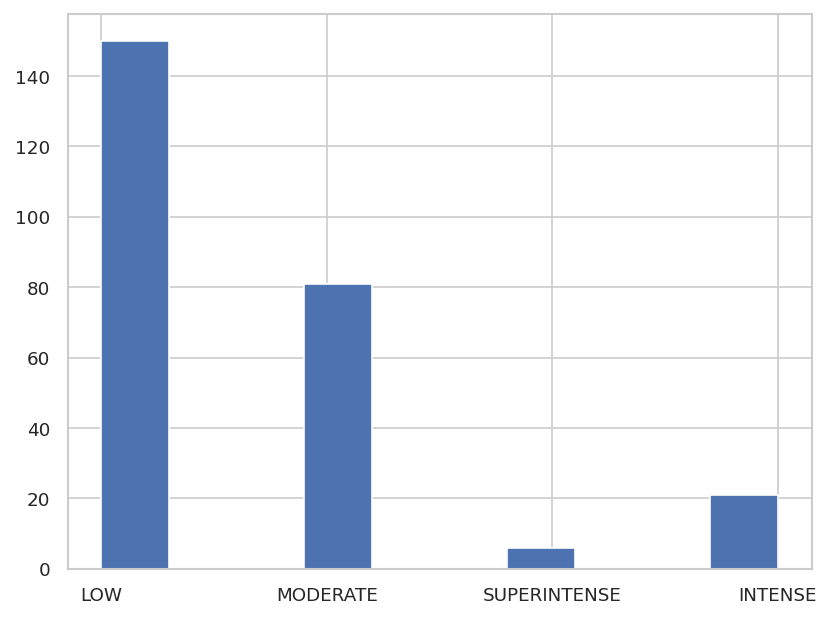

In [9]:
# Plot a histogram of the storm classifications
plt.hist(summary_df_asy['classification'], align='mid')
# Print the count of each storm classification
print(summary_df_asy['classification'].value_counts())
# Print the total number of storms
print('Total number of storms:', len(summary_df_asy))

In [10]:
# Get the indices of storms classified as 'LOW'
low_indices = summary_df_asy.loc[(summary_df_asy['Max ASY-H'] > utils.ASY_H_THRESHOLD_LOW ) & 
                                ((summary_df_asy['Max ASY-H'] < utils.ASY_H_THRESHOLD_MODERATE ))].index

# Get the indices of storms classified as 'MODERATE'
moderate_indices = summary_df_asy.loc[(summary_df_asy['Max ASY-H'] > utils.ASY_H_THRESHOLD_MODERATE ) & 
                                ((summary_df_asy['Max ASY-H'] < utils.ASY_H_THRESHOLD_INTENSE ))].index

# Get the indices of storms classified as 'INTENSE'
intense_indices  = summary_df_asy.loc[(summary_df_asy['Max ASY-H'] > utils.ASY_H_THRESHOLD_INTENSE ) & 
                                ((summary_df_asy['Max ASY-H'] < utils.ASY_H_THRESHOLD_SUPERINTENSE ))].index

# Get the indices of storms classified as 'SUPERINTENSE'
superintense_indices  = summary_df_asy.loc[summary_df_asy['Max ASY-H'] > utils.ASY_H_THRESHOLD_SUPERINTENSE].index

# Superposed Epoch plots <a class="anchor" id="section_2"></a>

## Forward <a class="anchor" id="section_2_1"></a>

Evaluating for indices L_
Storm 0 1981-03-05 11:50:00 1981-03-10 11:50:00
Storm 5 1982-02-02 11:30:00 1982-02-07 11:30:00
Storm 8 1982-08-07 06:00:00 1982-08-12 06:00:00
Storm 11 1982-10-31 19:00:00 1982-11-05 19:00:00
Storm 13 1982-12-22 03:10:00 1982-12-27 03:10:00
Storm 16 1983-05-11 17:55:00 1983-05-16 17:55:00
Storm 18 1983-06-13 04:20:00 1983-06-18 04:20:00
Storm 19 1983-08-08 04:20:00 1983-08-13 04:20:00
Storm 20 1983-10-04 15:00:00 1983-10-09 15:00:00
Storm 21 1983-11-11 20:30:00 1983-11-16 20:30:00
Storm 23 1984-04-26 15:35:00 1984-05-01 15:35:00
Storm 24 1984-07-13 07:00:00 1984-07-18 07:00:00
Storm 25 1984-09-04 15:30:00 1984-09-09 15:30:00
Storm 26 1984-09-19 12:30:00 1984-09-24 12:30:00
Storm 27 1984-11-16 03:10:00 1984-11-21 03:10:00
Storm 28 1985-02-28 03:00:00 1985-03-05 03:00:00
Storm 29 1985-04-09 14:15:00 1985-04-14 14:15:00
Storm 31 1985-06-09 22:20:00 1985-06-14 22:20:00
Storm 32 1985-09-19 10:15:00 1985-09-24 10:15:00
Storm 33 1985-10-05 20:10:00 1985-10-10 20:10:

Storm 224 2015-09-09 09:30:00 2015-09-14 09:30:00
Storm 225 2015-10-07 19:00:00 2015-10-12 19:00:00
Storm 234 2016-12-21 16:15:00 2016-12-26 16:15:00
Storm 237 2017-07-16 13:25:00 2017-07-21 13:25:00
Storm 238 2017-09-08 00:35:00 2017-09-13 00:35:00
Storm 241 2018-08-26 04:55:00 2018-08-31 04:55:00
Storm 251 2021-11-04 09:10:00 2021-11-09 09:10:00
Evaluating for indices I_
Storm 9 1982-09-06 12:10:00 1982-09-11 12:10:00
Storm 12 1982-11-24 18:10:00 1982-11-29 18:10:00
Storm 15 1983-02-04 17:10:00 1983-02-09 17:10:00
Storm 36 1986-02-08 20:50:00 1986-02-13 20:50:00
Storm 48 1988-04-03 19:30:00 1988-04-08 19:30:00
Storm 61 1989-09-19 03:50:00 1989-09-24 03:50:00
Storm 62 1989-10-21 12:15:00 1989-10-26 12:15:00


/tmp/ipykernel_3542/1975051802.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  superposed_df[f'{name}Superposed'] = superposed_df.mean(axis = 1)


Storm 76 1991-06-05 17:00:00 1991-06-10 17:00:00
Storm 77 1991-07-13 16:20:00 1991-07-18 16:20:00
Storm 85 1992-05-10 10:10:00 1992-05-15 10:10:00
Storm 133 1998-05-04 05:45:00 1998-05-09 05:45:00
Storm 137 1998-09-25 06:30:00 1998-09-30 06:30:00
Storm 153 2000-07-15 21:15:00 2000-07-20 21:15:00
Storm 159 2001-04-11 16:10:00 2001-04-16 16:10:00
Storm 161 2001-11-06 02:45:00 2001-11-11 02:45:00
Storm 162 2001-11-24 07:10:00 2001-11-29 07:10:00
Storm 172 2003-05-29 22:25:00 2003-06-03 22:25:00
Storm 184 2004-07-26 23:20:00 2004-07-31 23:20:00
Storm 185 2004-11-08 04:05:00 2004-11-13 04:05:00
Storm 186 2005-01-21 17:40:00 2005-01-26 17:40:00
Storm 221 2015-06-22 19:45:00 2015-06-27 19:45:00
Evaluating for indices SI_
Storm 7 1982-07-14 00:00:00 1982-07-19 00:00:00
Storm 55 1989-03-13 22:05:00 1989-03-18 22:05:00
Storm 75 1991-03-24 04:30:00 1991-03-29 04:30:00
Storm 81 1991-11-09 00:15:00 1991-11-14 00:15:00
Storm 150 2000-04-07 00:25:00 2000-04-12 00:25:00
Storm 178 2003-10-29 20:05:00 2

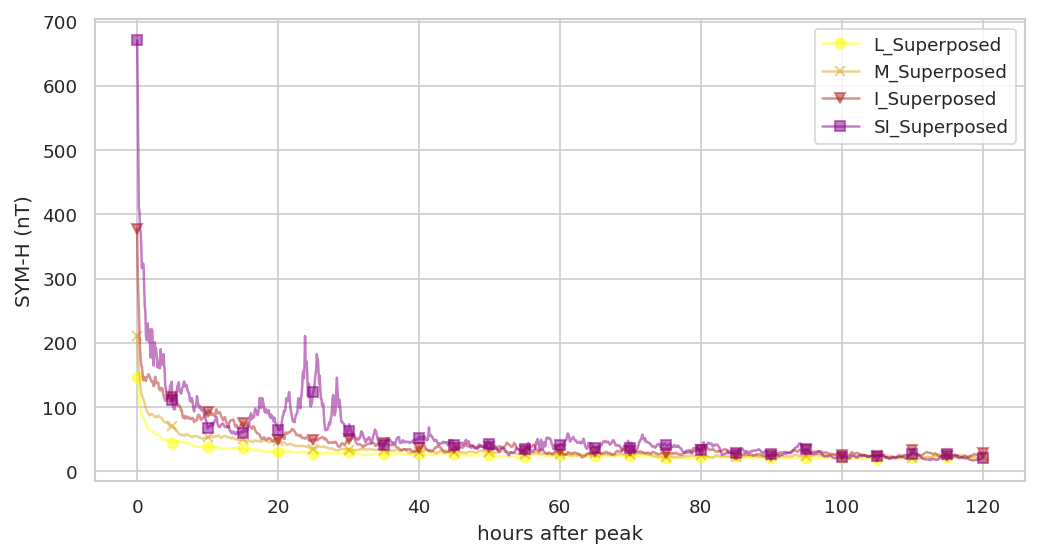

In [11]:
# Define names and indices for different storm classifications
names = ['L_', 'M_', 'I_', 'SI_']
names_long = ['Low_Storms', 'Moderate_Storms', 'Intense_Storms', 'SuperIntense_Storms']
classification = ['Low', 'Moderate', 'Intense', 'SuperIntense']
all_indices = [low_indices, moderate_indices, intense_indices, superintense_indices]

# Create a dataframe for the forward superposed epoch plot
superposed_forward = pd.DataFrame(index = pd.timedelta_range(start = '0 days', end = f'{utils.SUPERPOSED_DAYS_AFTER} days', freq = '5min'))
superposed_dfs_forward = []

# Define the time offset for the forward superposed epoch plot
delta_forward = pd.DateOffset(days = utils.SUPERPOSED_DAYS_AFTER)

for i in range(len(all_indices)):
    indices = all_indices[i]
    name = names[i]
    superposed_df = pd.DataFrame(index = pd.timedelta_range(start = '0 days', end = f'{utils.SUPERPOSED_DAYS_AFTER} days', freq = '5min'))
    
    print('Evaluating for indices',name)
    
    dfs_tmp = []
    
    for storm_index in indices:        
        # Get data for the current storm
        strm = utils.get_storm(dfx, summary_df_asy, storm_index)
        strm = strm[['ASY_H']]
        
        # Find the time index of the ASY_H peak
        idxmax = strm['ASY_H'].idxmax()
        
        # Rename the columns to include storm index
        strm.columns = [[f'storm-{storm_index}']]
        
        # Extract a time window of data before the index peak
        strm = strm[idxmax : idxmax + delta_forward].copy()
        print('Storm', storm_index, strm.index[0], strm.index[-1])
        
        # Create a new index for the data in 5-minute intervals
        strm.index = pd.timedelta_range(start = '0 days', freq = '5min', periods = len(strm))        
        dfs_tmp.append(strm)   
        
    superposed_df = pd.concat(dfs_tmp, axis = 1)
    # Average the storms for the superposed epoch plot
    superposed_df[f'{name}Superposed'] = superposed_df.mean(axis = 1)
    superposed_dfs_forward.append(superposed_df.copy())
    
    # Add the superposed data to the main superposed dataframe
    superposed_forward[f'{name}Superposed'] = superposed_df[f'{name}Superposed']
    

# Create a new column in the main dataframe for hours to ease the plotting
superposed_forward['hours'] = superposed_forward.index / pd.Timedelta(hours = 1)

# Plot the superposed epoch storms for each class
fig, ax = plt.subplots(1, figsize = utils.global_figsize)
ax = superposed_forward.plot(x = 'hours', y ='L_Superposed', color = utils.COLOR_LOW, marker = 'o', ax = ax, markevery = 5 * 12, alpha = 0.5)
ax = superposed_forward.plot(x = 'hours', y ='M_Superposed', color = utils.COLOR_MODERATE, marker = 'x', ax = ax, markevery = 5 * 12, alpha = 0.5)
ax = superposed_forward.plot(x = 'hours', y ='I_Superposed', color = utils.COLOR_INTENSE, marker = "v", ax = ax, markevery = 5 * 12, alpha = 0.5)
ax = superposed_forward.plot(x = 'hours', y ='SI_Superposed', color = utils.COLOR_SUPERINTENSE, marker = "s", ax = ax, markevery = 5 * 12, alpha = 0.5, ylabel = 'SYM-H (nT)', xlabel = 'hours after peak')
plt.show();

## Backward <a class="anchor" id="section_2_2"></a>

Evaluating for indices L_
Storm 0 1981-02-28 11:50:00 1981-03-05 11:50:00
Storm 5 1982-01-28 11:30:00 1982-02-02 11:30:00
Storm 8 1982-08-02 06:00:00 1982-08-07 06:00:00
Storm 11 1982-10-26 19:00:00 1982-10-31 19:00:00
Storm 13 1982-12-17 03:10:00 1982-12-22 03:10:00
Storm 16 1983-05-06 17:55:00 1983-05-11 17:55:00
Storm 18 1983-06-08 04:20:00 1983-06-13 04:20:00
Storm 19 1983-08-03 04:20:00 1983-08-08 04:20:00
Storm 20 1983-09-29 15:00:00 1983-10-04 15:00:00
Storm 21 1983-11-06 20:30:00 1983-11-11 20:30:00
Storm 23 1984-04-21 15:35:00 1984-04-26 15:35:00
Storm 24 1984-07-08 07:00:00 1984-07-13 07:00:00
Storm 25 1984-08-30 15:30:00 1984-09-04 15:30:00
Storm 26 1984-09-14 12:30:00 1984-09-19 12:30:00
Storm 27 1984-11-11 03:10:00 1984-11-16 03:10:00
Storm 28 1985-02-23 03:00:00 1985-02-28 03:00:00
Storm 29 1985-04-04 14:15:00 1985-04-09 14:15:00
Storm 31 1985-06-04 22:20:00 1985-06-09 22:20:00
Storm 32 1985-09-14 10:15:00 1985-09-19 10:15:00
Storm 33 1985-09-30 20:10:00 1985-10-05 20:10:

/tmp/ipykernel_3542/657064069.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  superposed_df[f'{name}Superposed'] = superposed_df.mean(axis = 1)


Storm 167 2002-09-26 11:20:00 2002-10-01 11:20:00
Storm 174 2003-07-07 05:40:00 2003-07-12 05:40:00
Storm 177 2003-09-12 13:35:00 2003-09-17 13:35:00
Storm 188 2005-05-10 08:45:00 2005-05-15 08:45:00
Storm 189 2005-05-25 15:05:00 2005-05-30 15:05:00
Storm 191 2005-09-06 06:35:00 2005-09-11 06:35:00
Storm 197 2006-12-10 00:05:00 2006-12-15 00:05:00
Storm 204 2011-07-31 21:50:00 2011-08-05 21:50:00
Storm 208 2012-03-04 09:55:00 2012-03-09 09:55:00
Storm 210 2012-06-12 13:10:00 2012-06-17 13:10:00
Storm 214 2013-03-12 12:20:00 2013-03-17 12:20:00
Storm 217 2013-09-27 05:50:00 2013-10-02 05:50:00
Storm 219 2015-01-02 10:40:00 2015-01-07 10:40:00
Storm 220 2015-03-12 13:55:00 2015-03-17 13:55:00
Storm 222 2015-08-10 12:00:00 2015-08-15 12:00:00
Storm 224 2015-09-04 09:30:00 2015-09-09 09:30:00
Storm 225 2015-10-02 19:00:00 2015-10-07 19:00:00
Storm 234 2016-12-16 16:15:00 2016-12-21 16:15:00
Storm 237 2017-07-11 13:25:00 2017-07-16 13:25:00
Storm 238 2017-09-03 00:35:00 2017-09-08 00:35:00


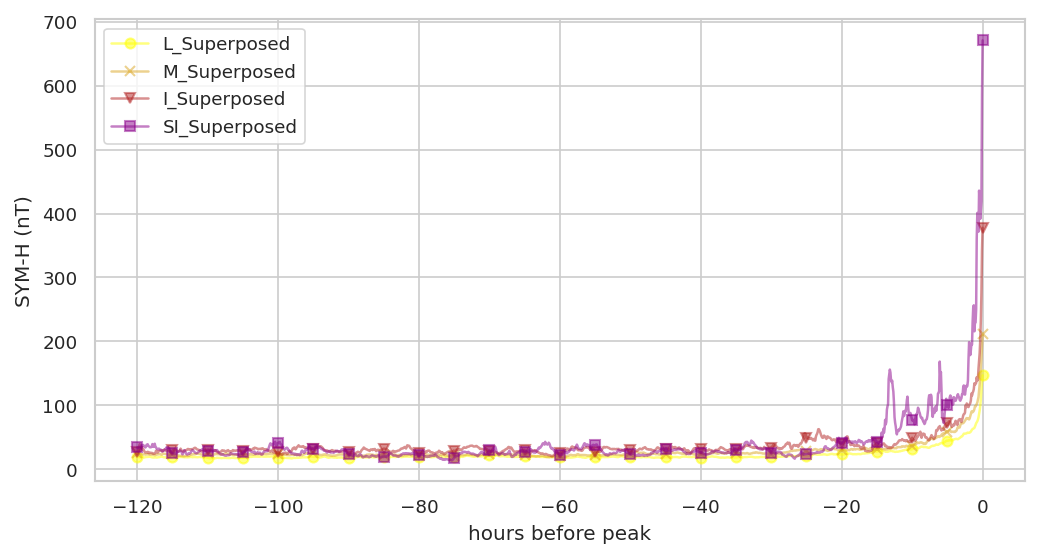

In [12]:
# Create a dataframe for the backward superposed epoch plot
superposed_backward = pd.DataFrame(index = pd.timedelta_range(start = f'-{utils.SUPERPOSED_DAYS_BEFORE} days', end = '0 days', freq = '5min'))
superposed_dfs_backward = []

# Define the time offset for the backward superposed epoch plot
delta_backward = pd.DateOffset(days = utils.SUPERPOSED_DAYS_BEFORE)

for i in range(len(all_indices)):
    indices = all_indices[i]
    name = names[i]
    superposed_df = pd.DataFrame(index = pd.timedelta_range(start = f'-{utils.SUPERPOSED_DAYS_BEFORE} days', end = '0 days', freq = '5min'))
    
    print('Evaluating for indices',name)
    
    dfs_tmp = []
    
    for storm_index in indices:        
        # Get data for the current storm
        strm = utils.get_storm(dfx, summary_df_asy, storm_index)
        strm = strm[['ASY_H']]        

        # Find the time index of the ASY_H peak
        idxmax = strm['ASY_H'].idxmax()
        
        # Rename the columns to include storm index
        strm.columns = [[f'storm-{storm_index}']]
        
        # Extract a time window of data before the index peak
        strm = strm[idxmax - delta_backward: idxmax].copy()
        print('Storm', storm_index, strm.index[0], strm.index[-1])
        
        # Create a new index for the data in 5-minute intervals
        strm.index = pd.timedelta_range(start = f'-{utils.SUPERPOSED_DAYS_AFTER} days', freq = '5min', periods = len(strm))        
        dfs_tmp.append(strm)
        
    superposed_df = pd.concat(dfs_tmp, axis = 1)
    # Average the storms for the superposed epoch plot
    superposed_df[f'{name}Superposed'] = superposed_df.mean(axis = 1)
    superposed_dfs_backward.append(superposed_df.copy())
    
    # Add the superposed data to the main superposed dataframe
    superposed_backward[f'{name}Superposed'] = superposed_df[f'{name}Superposed']    
        
# Create a new column in the main dataframe for hours to ease the plotting
superposed_backward['hours'] = superposed_backward.index / pd.Timedelta(hours = 1)

# Plot the superposed epoch storms for each class
fig, ax = plt.subplots(1, figsize = utils.global_figsize)
ax = superposed_backward.plot(x = 'hours', y ='L_Superposed', color = utils.COLOR_LOW, marker = 'o', ax = ax, markevery = 5 * 12, alpha = 0.5)
ax = superposed_backward.plot(x = 'hours', y ='M_Superposed', color = utils.COLOR_MODERATE, marker = 'x', ax = ax, markevery = 5 * 12, alpha = 0.5)
ax = superposed_backward.plot(x = 'hours', y ='I_Superposed', color = utils.COLOR_INTENSE, marker = "v", ax = ax, markevery = 5 * 12, alpha = 0.5)
ax = superposed_backward.plot(x = 'hours', y ='SI_Superposed', color = utils.COLOR_SUPERINTENSE, marker = "s", ax = ax, markevery = 5 * 12, alpha = 0.5, ylabel = 'SYM-H (nT)', xlabel = 'hours before peak')
plt.show();

## Both directions <a class="anchor" id="section_2_3"></a>

In [13]:
# Create a dataframe for the superposed epoch plot in both directions
superposed_total = pd.DataFrame(index = pd.timedelta_range(start = f'-{utils.SUPERPOSED_DAYS_BEFORE} days', end = f'{utils.SUPERPOSED_DAYS_AFTER} days', freq = '5min'))
superposed_dfs_total = []

sum_cols = [ "Start date", "End date", "Max ASY-H", "Classification"]
# Columns for the output .csv with the dates used for the superposed epoch plot
dates_superposed = pd.DataFrame(columns = sum_cols)

for i in range(len(all_indices)):
    indices = all_indices[i]
    name = names[i]
    superposed_df = pd.DataFrame(index = pd.timedelta_range(start = f'-{utils.SUPERPOSED_DAYS_BEFORE} days', end = f'{utils.SUPERPOSED_DAYS_AFTER} days', freq = '5min'))
    
    print('Evaluating for indices',name)
    
    dfs_tmp = []
    
    for storm_index in indices:  
        # Get data for the current storm
        strm = utils.get_storm(dfx, summary_df_asy, storm_index)
        strm = strm[['ASY_H']]        
        idxmax = strm['ASY_H'].idxmax()
        
        # Create a dataframe with storm information for later on saving the dates to a .csv file
        dates_superposed = pd.concat([dates_superposed, 
                                      pd.DataFrame(
                                          data = [[idxmax - delta_backward, 
                                                  idxmax + delta_forward,
                                                  strm['ASY_H'].max(),
                                                  classification[i]]],
                                          columns = sum_cols)], 
                                     ignore_index = True)
        strm.columns = [[f'storm-{storm_index}']]
        strm = strm[idxmax - delta_backward : idxmax + delta_forward].copy()
        print('Storm', storm_index, strm.index[0], strm.index[-1])

        # Create a new index for the data in 5-minute intervals
        strm.index = pd.timedelta_range(start = f'-{utils.SUPERPOSED_DAYS_BEFORE} days', freq = '5min', periods = len(strm))        
        dfs_tmp.append(strm)

    # Average the storms for the superposed epoch plot
    superposed_df = pd.concat(dfs_tmp, axis = 1)
    superposed_df[f'{name}Superposed'] = superposed_df.mean(axis = 1)
    superposed_dfs_total.append(superposed_df.copy())
    
    superposed_total[f'{name}Superposed'] = superposed_df[f'{name}Superposed']
    
        
# Create a new column in the main dataframe for hours to ease the plotting
superposed_total['hours'] = superposed_total.index / pd.Timedelta(hours = 1)

Evaluating for indices L_
Storm 0 1981-02-28 11:50:00 1981-03-10 11:50:00
Storm 5 1982-01-28 11:30:00 1982-02-07 11:30:00
Storm 8 1982-08-02 06:00:00 1982-08-12 06:00:00
Storm 11 1982-10-26 19:00:00 1982-11-05 19:00:00
Storm 13 1982-12-17 03:10:00 1982-12-27 03:10:00
Storm 16 1983-05-06 17:55:00 1983-05-16 17:55:00
Storm 18 1983-06-08 04:20:00 1983-06-18 04:20:00
Storm 19 1983-08-03 04:20:00 1983-08-13 04:20:00
Storm 20 1983-09-29 15:00:00 1983-10-09 15:00:00
Storm 21 1983-11-06 20:30:00 1983-11-16 20:30:00
Storm 23 1984-04-21 15:35:00 1984-05-01 15:35:00
Storm 24 1984-07-08 07:00:00 1984-07-18 07:00:00
Storm 25 1984-08-30 15:30:00 1984-09-09 15:30:00
Storm 26 1984-09-14 12:30:00 1984-09-24 12:30:00
Storm 27 1984-11-11 03:10:00 1984-11-21 03:10:00
Storm 28 1985-02-23 03:00:00 1985-03-05 03:00:00
Storm 29 1985-04-04 14:15:00 1985-04-14 14:15:00
Storm 31 1985-06-04 22:20:00 1985-06-14 22:20:00
Storm 32 1985-09-14 10:15:00 1985-09-24 10:15:00
Storm 33 1985-09-30 20:10:00 1985-10-10 20:10:

/tmp/ipykernel_3542/482903824.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  superposed_df[f'{name}Superposed'] = superposed_df.mean(axis = 1)


Storm 1 1981-04-08 03:55:00 1981-04-18 03:55:00
Storm 2 1981-05-10 06:25:00 1981-05-20 06:25:00
Storm 3 1981-07-20 14:15:00 1981-07-30 14:15:00
Storm 4 1981-10-09 02:20:00 1981-10-19 02:20:00
Storm 6 1982-02-25 10:15:00 1982-03-07 10:15:00
Storm 10 1982-09-17 06:35:00 1982-09-27 06:35:00
Storm 14 1983-01-05 05:55:00 1983-01-15 05:55:00
Storm 17 1983-05-19 18:15:00 1983-05-29 18:15:00
Storm 22 1984-03-30 17:45:00 1984-04-09 17:45:00
Storm 30 1985-04-16 02:45:00 1985-04-26 02:45:00
Storm 37 1986-09-07 04:40:00 1986-09-17 04:40:00
Storm 41 1987-08-20 14:05:00 1987-08-30 14:05:00
Storm 47 1988-02-17 07:40:00 1988-02-27 07:40:00
Storm 51 1988-10-05 12:15:00 1988-10-15 12:15:00
Storm 52 1988-11-25 10:15:00 1988-12-05 10:15:00
Storm 54 1989-01-15 16:10:00 1989-01-25 16:10:00
Storm 56 1989-04-30 01:10:00 1989-05-10 01:10:00
Storm 57 1989-05-18 15:30:00 1989-05-28 15:30:00
Storm 58 1989-06-05 16:40:00 1989-06-15 16:40:00
Storm 59 1989-08-10 12:30:00 1989-08-20 12:30:00
Storm 60 1989-08-24 05:05

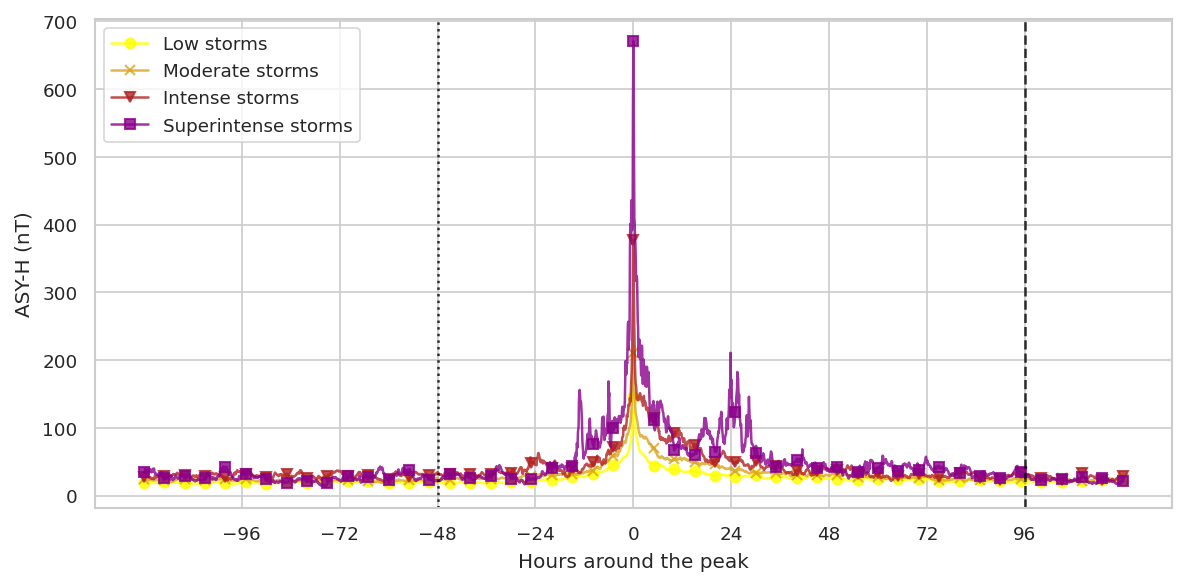

In [14]:
# Plot the superposed epoch plot with vertical lines on the limits for the start and end of the storm
fig, ax = plt.subplots(1, figsize = utils.global_figsize)
ax = superposed_total.plot(x = 'hours', y ='L_Superposed', color = utils.COLOR_LOW, marker = 'o', ax = ax, markevery = 5 * 12, alpha = 0.8, label = 'Low storms')
ax = superposed_total.plot(x = 'hours', y ='M_Superposed', color = utils.COLOR_MODERATE, marker = 'x', ax = ax, markevery = 5 * 12, alpha = 0.8, label = 'Moderate storms')
ax = superposed_total.plot(x = 'hours', y ='I_Superposed', color = utils.COLOR_INTENSE, marker = "v", ax = ax, markevery = 5 * 12, alpha = 0.8, label = 'Intense storms')
ax = superposed_total.plot(x = 'hours', y ='SI_Superposed', color = utils.COLOR_SUPERINTENSE, marker = "s", ax = ax, markevery = 5 * 12, alpha = 0.8, ylabel = 'ASY-H (nT)', xlabel = 'Hours around the peak', label = 'Superintense storms')
ax.axvline(x = 24 * 4, linestyle = 'dashed', color = 'black', alpha = 0.8)
ax.axvline(x = -24 * 2, linestyle = 'dotted', color = 'black', alpha = 0.8)
ax.legend(['Low storms', 'Moderate storms', 'Intense storms', 'Superintense storms'])
plt.xticks([-96, -72, -48, -24, 0, 24, 48, 72, 96])
plt.tight_layout();
plt.savefig('figs/asy-superposed.png')
plt.show();

## PELT analysis for identifying changepoints  <a class="anchor" id="section_2_4"></a>

Total number of detected changepoints for the Low storms class: 12
Number of changepoints before -2 days: 0 | 0%
Number of changepoints between -2 days and 4 days: 12 | 100%
Number of changepoints after 4 days: 0 | 0%
Total number of detected changepoints for the Moderate storms class: 13
Number of changepoints before -2 days: 1 | 8%
Number of changepoints between -2 days and 4 days: 12 | 92%
Number of changepoints after 4 days: 0 | 0%
Total number of detected changepoints for the Intense storms class: 17
Number of changepoints before -2 days: 1 | 6%
Number of changepoints between -2 days and 4 days: 15 | 88%
Number of changepoints after 4 days: 1 | 6%
Total number of detected changepoints for the Superintense storms class: 22
Number of changepoints before -2 days: 3 | 14%
Number of changepoints between -2 days and 4 days: 18 | 82%
Number of changepoints after 4 days: 1 | 5%


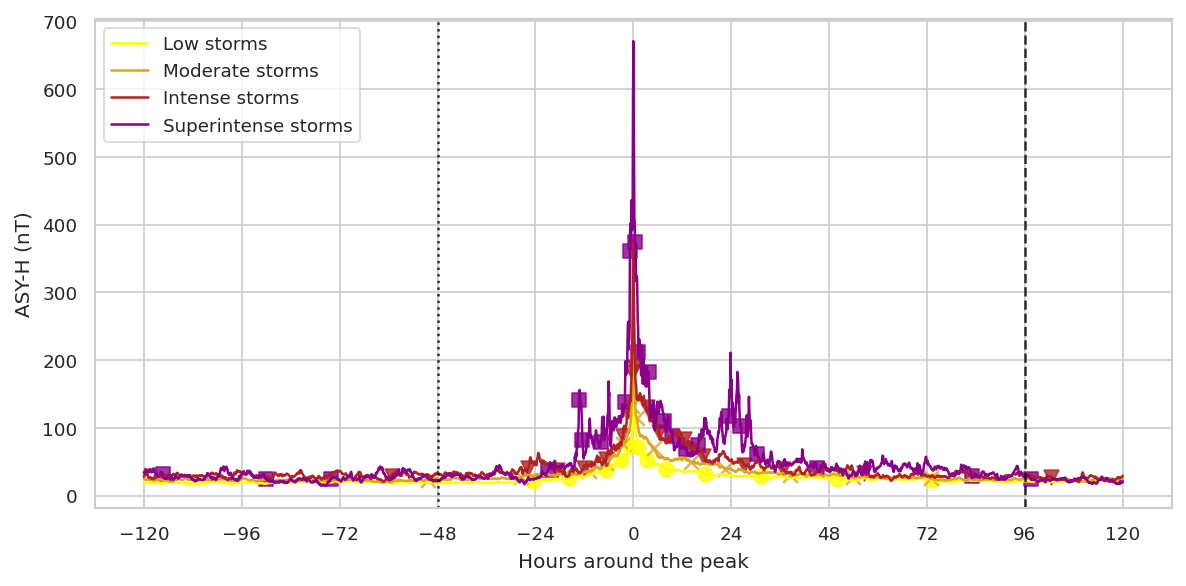

In [53]:
# Define markers, columns to analyze, column names, and colors for plotting
markers = ['o', 'x', 'v', 's']
columns_to_analyze = ['L_Superposed', 'M_Superposed', 'I_Superposed', 'SI_Superposed']
column_names = ['Low storms', 'Moderate storms', 'Intense storms', 'Superintense storms']
colors = [utils.COLOR_LOW, utils.COLOR_MODERATE, utils.COLOR_INTENSE, utils.COLOR_SUPERINTENSE]

plt.figure(figsize=utils.global_figsize)

# Calculate the change points for all the classes in the superposed epoch analysis
for i, col_name in enumerate(columns_to_analyze):
    data = np.array(np.round(superposed_total[col_name].values, 3))
    
    # Perform change point detection using the Pelt Search algorithm
    algo = rpt.Pelt(model="l1", min_size=10, jump=5).fit(data)
    result = algo.predict(pen=200)
    result.pop()
    
    # Plot the original data
    plt.plot(superposed_total['hours'], data, color=colors[i], label=column_names[i])    
    # Plot markers at change points detected by the algorithm
    plt.scatter(superposed_total.iloc[result]['hours'].values, superposed_total.iloc[result][col_name].values,
               alpha=0.8, color=colors[i], label='_nolegend_', marker=markers[i], s=50)
    
    result = np.array(result)
    histogram = np.histogram(result, bins = [0,864, 2592, 2881])
    print(f'Total number of detected changepoints for the {column_names[i]} class: {len(result)}')
    print(f'Number of changepoints before -2 days: {histogram[0][0]} | {histogram[0][0] / len(result) * 100:.0f}%')
    print(f'Number of changepoints between -2 days and 4 days: {histogram[0][1]} | {histogram[0][1] / len(result) * 100:.0f}%')
    print(f'Number of changepoints after 4 days: {histogram[0][2]} | {histogram[0][2] / len(result) * 100:.0f}%')
        
# Add labels, legends, and vertical lines for reference
plt.xlabel('Hours around the peak')
plt.ylabel('ASY-H (nT)')
plt.legend(['Low storms', 'Moderate storms', 'Intense storms', 'Superintense storms'])
plt.xticks([-120, -96, -72, -48, -24, 0, 24, 48, 72, 96, 120])
plt.axvline(x=24 * 4, linestyle='dashed', color='black', alpha=0.8)
plt.axvline(x=-24 * 2, linestyle='dotted', color='black', alpha=0.8)

# Adjust layout, save the figure to a file, and display it
plt.tight_layout()
plt.savefig('figs/asy-superposed-cp.png')
plt.show()

In [54]:
# Save the dates for the superposed epoch plot to a csv file in the format
# Start Date, End Date, Storm duration, Maximum ASY-H, Classification
dates_superposed['Max ASY-H'] = dates_superposed['Max ASY-H'].astype(int)
dates_superposed.to_csv('./data/dates_asy_superposed.csv', index = False)